In [1]:
import mle as mle
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import numpy as np
from datetime import timedelta, datetime
import backtesting as bt 

plt.style.use('ggplot')


### Create data for analysis

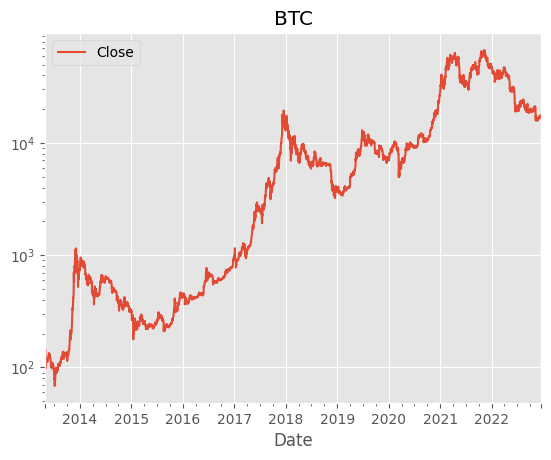

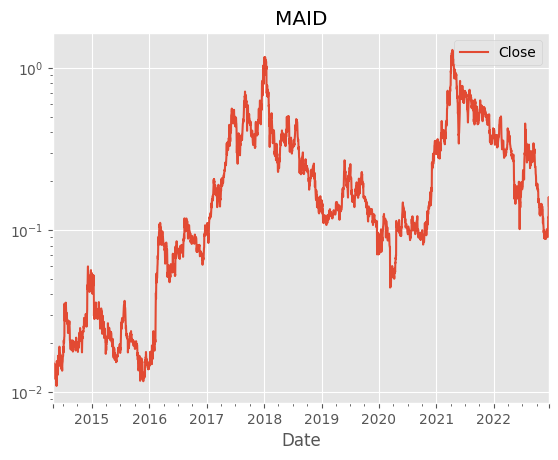

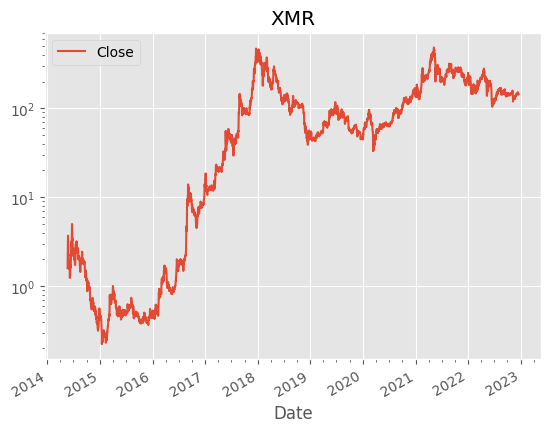

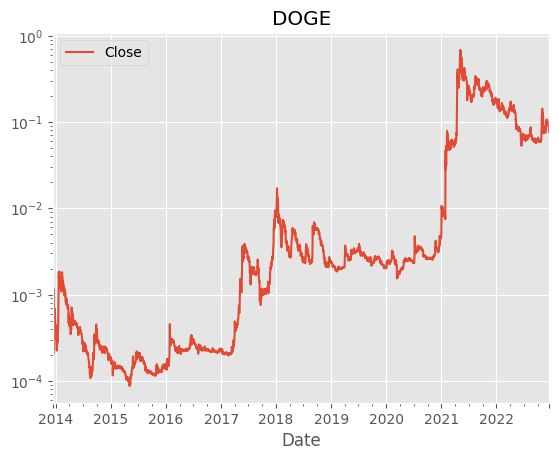

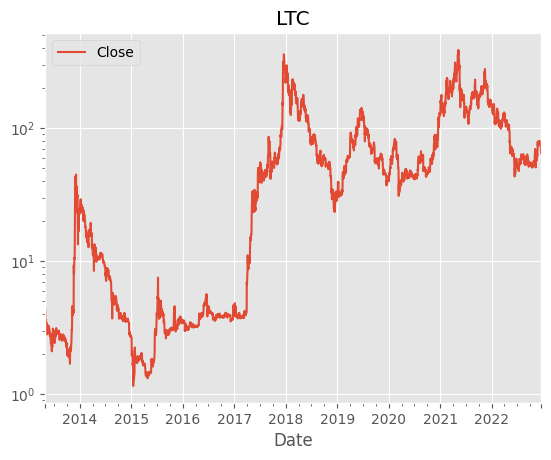

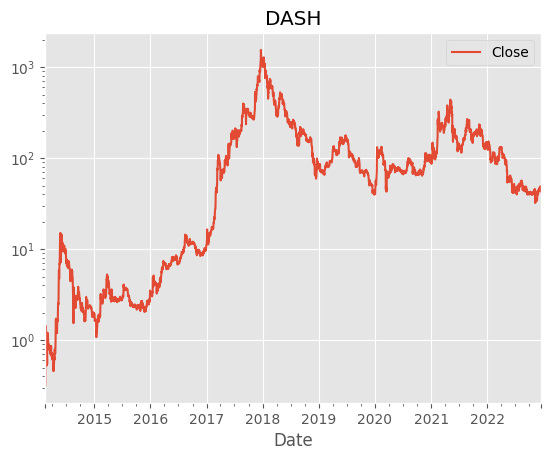

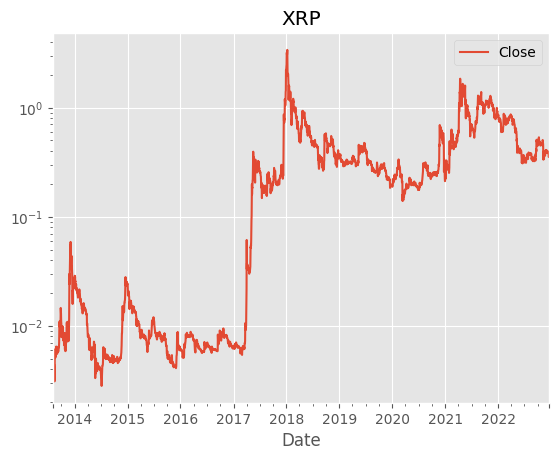

In [2]:
coins = ['BTC', 'MAID', 'XMR', 'DOGE', 'LTC', 'DASH', 'XRP']
dfs = dict()
for coin in coins:
    df = pd.read_csv(
        f'../data/prices/{coin}.csv').set_index('Date').sort_index()
    df.index = pd.to_datetime(df.index)
    df['log_return'] = np.log(1 + df['Close'].pct_change())
    df['loss'] = -df['log_return']
    dfs[coin.lower()] = df

    ax = df[['Close']].plot(logy=True)
    months = mdates.MonthLocator((1, 4, 7, 10))
    ax.xaxis.set_minor_locator(months)
    ax.xaxis.tick_bottom()

    plt.title(coin)
    plt.show()


best_dists = {
    'MAID': 'Laplace',
    'BTC': 'Generalized Hyperbolic',
    'DASH': 'Normalized Inverse Gaussian',
    'XRP':'Normalized Inverse Gaussian',
    'XMR': 'Normalized Inverse Gaussian',
    'LTC' :'Generalized Hyperbolic',
    'DOGE': 'Generalized T'
}


### Fit models to all data

In [3]:
dists = [mle.Laplace, mle.SkewT, mle.SkewedStudent, mle.GeneralizedT,
         mle.NormalizedInverseGaussian, mle.GeneralizedHyperbolic, mle.StudentT,
         mle.AsymmetricStudentT]

end_date = pd.to_datetime('28-02-2017', format='%d-%m-%Y')
start_date = pd.to_datetime('23-06-2014', format='%d-%m-%Y')

info_list = []

for coin in coins:
    coin_df = dfs[coin.lower()]
    df = coin_df[(coin_df.index >= start_date) & (coin_df.index <= end_date)]
    # df = coin_df
    for dist in dists:

        fitted_dist = dist()
        fitted_dist.mle(df['loss'])
        info_dict = fitted_dist.info_dict()
        info_dict['coin'] = coin

        info_list.append(info_dict)
info_df = pd.DataFrame(info_list)


c:\Users\George\projects\masters\stats_methods_cw\venv\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\George\projects\masters\stats_methods_cw\venv\lib\site-packages\scipy\optimize\_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
c:\Users\George\projects\masters\stats_methods_cw\george\mle.py:211: RuntimeWarning: overflow encountered in double_scalars
  return (tao / (2*sigma*nu**(1/tao) * beta(nu, 1/tao)))*(1 + 1/nu * np.abs((x-mu)/sigma)**tao)**(-(nu+1/tao))
c:\Users\George\projects\masters\stats_methods_cw\george\mle.py:252: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.pdf(x, mu, delta, alpha, beta)))
c:\Users\George\projects\masters\stats_methods_cw\venv\lib\site-packages\scipy\stats\_continuous_distns.py:4665: RuntimeWa

### Add qq plots


In [16]:
def qqplot(pydist):
    qs = list(np.linspace(0.01, 0.25, 12)) + \
        list(np.linspace(0.26, 0.75, 10))+list(np.linspace(0.76, 0.99, 12))

    quantiles = []
    for i in qs:
        quantiles.append(pydist.quantile(i))

    observed_quantiles = np.quantile(pydist.data.dropna().values, qs)
    fig, ax = plt.subplots()
    ax.scatter(quantiles, observed_quantiles)
    
    return fig, ax


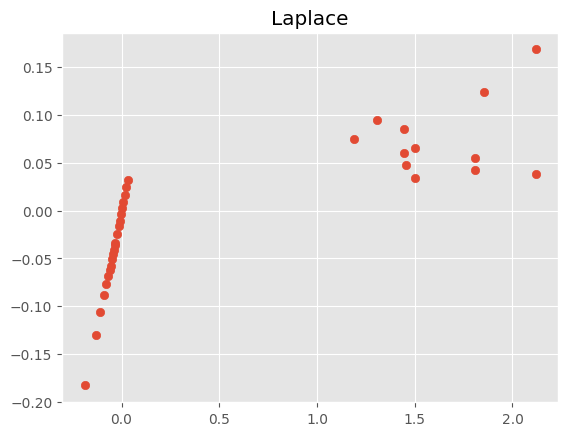

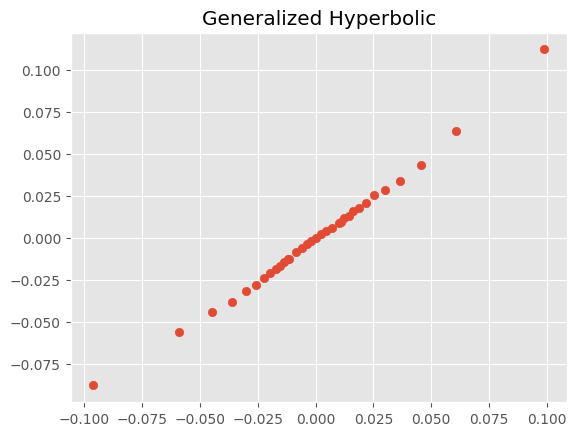

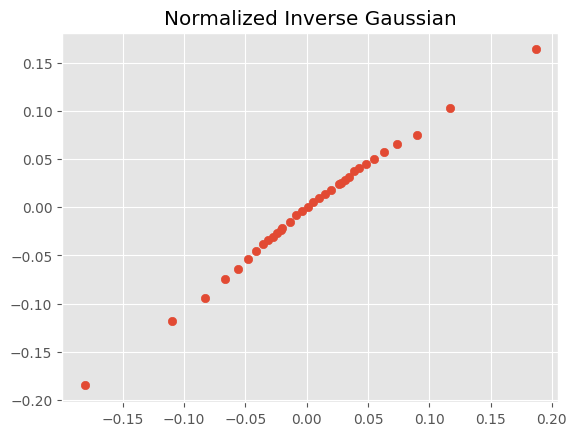

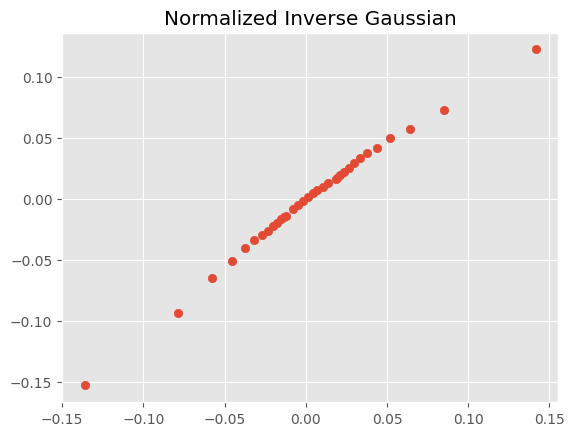

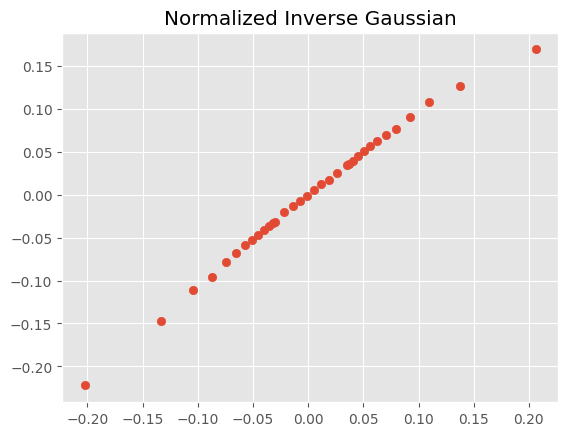

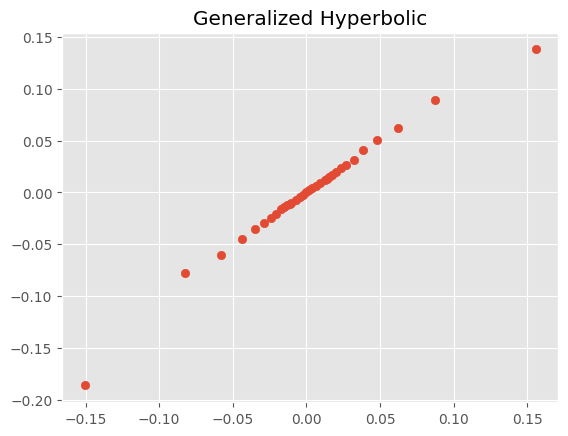

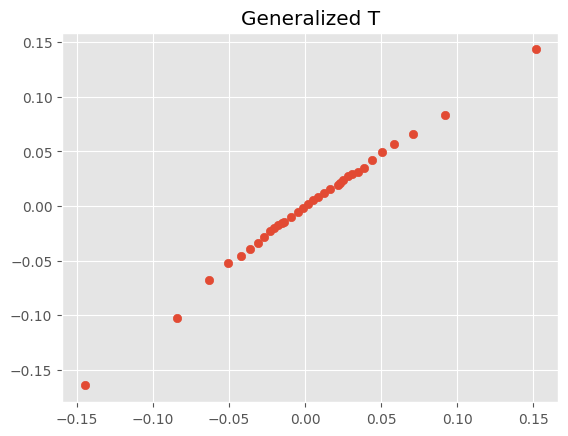

In [17]:

for coin, dist in best_dists.items():

    pydist = info_df[(info_df['coin']==coin)&(info_df['dist']==dist)]['pydist'].iloc[0]

    fig, ax = qqplot(pydist)
    ax.set_title(pydist.name)
    plt.show()


### Analyse fit stability over time 

- Calculate fit parameters over a rolling window
- Plot data and save to file

In [ ]:
# ~ 9m runtime

info_list = []
jump = 90
start_to_end_days = 981

start_date = pd.to_datetime('23-06-2014', format='%d-%m-%Y')
end_date = start_date + timedelta(days=start_to_end_days)


while end_date <= datetime.now():

    for coin in coins:
        coin_df = dfs[coin.lower()]
        df = coin_df[(coin_df.index >= start_date)
                     & (coin_df.index <= end_date)]
        # df = coin_df
        for dist in dists:

            fitted_dist = dist()
            fitted_dist.mle(df['log_return'])
            info_dict = fitted_dist.info_dict()
            info_dict['coin'] = coin
            info_dict['start_date'] = start_date
            info_dict['end_date'] = end_date

            info_list.append(info_dict)

    start_date = start_date + timedelta(days=jump)
    end_date = start_date + timedelta(days=start_to_end_days)


In [ ]:
params_over_time = pd.DataFrame(info_list)

for coin in coins:

    tmp = params_over_time[params_over_time['coin'] == coin]
    tmp = tmp[['end_date', 'dist', 'AIC']].set_index('end_date')
    tmp = tmp.pivot(columns='dist')

    tmp.columns = [col[1] for col in tmp.columns]

    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

    ax1 = tmp.plot(ax=ax1)
    ax1.set_title(f"{coin.upper()}")
    ax1.set_ylabel('AIC')
    ax1.legend(loc=2, fontsize=8)

    ax2 = tmp.rank(axis=1).plot(ax=ax2)
    ax2.set_ylabel('Ranking')
    ax2.set_xlabel('End Date')
    ax2.get_legend().remove()

    plt.savefig(f'../plots/fit_over_time/{coin}.png')
    plt.clf()


### Kupiec’s plots

In [8]:
def kupic_plot(dist):

    quantiles = np.linspace(0.9,0.999,11)
    vars = [dist.quantile(quantile) for quantile in quantiles]

    p_vals = []

    for alpha, var in zip(quantiles, vars):

        num_days = dist.data.shape[0]
        violations = (dist.data>var).sum()
        viol_mask = (dist.data>var)

        likelihood_uc = bt.lr_uc(alpha, viol_mask)
        
        p_val_uc = bt.p_chi2(likelihood_uc)
        expected_viols = (1-alpha)*num_days


        p_vals.append(p_val_uc)


    fig, ax = plt.subplots(1,1)
    
    ax.plot(quantiles, p_vals); 
    ax.axhline(0.05, color='k')
    return ax
    


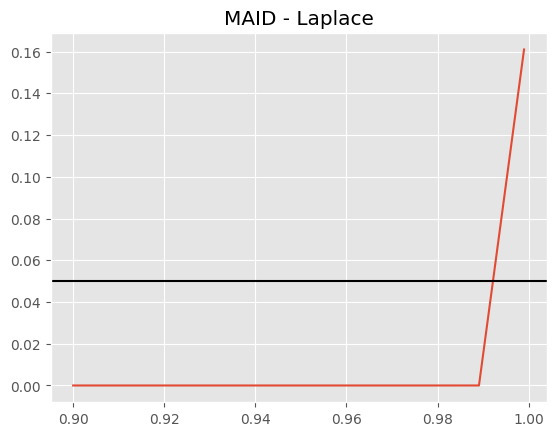

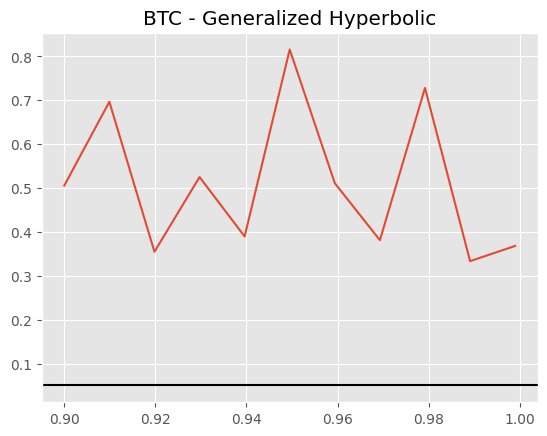

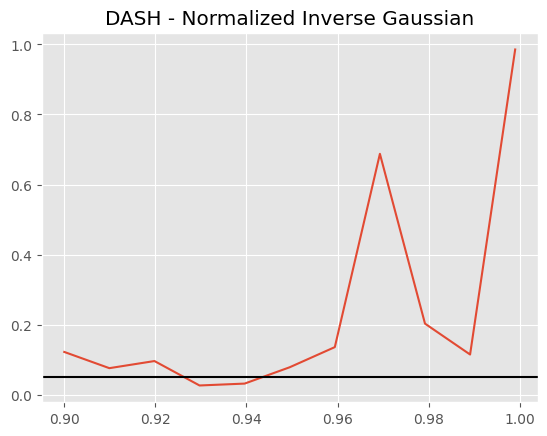

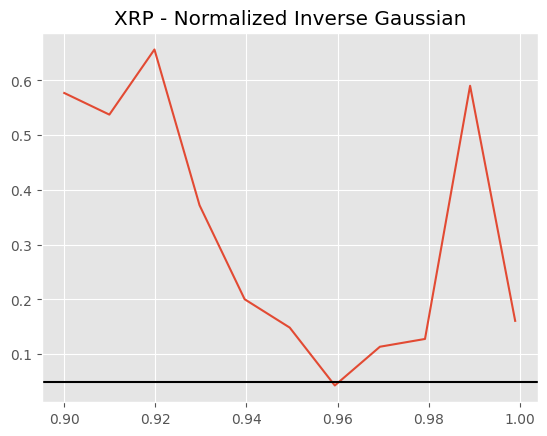

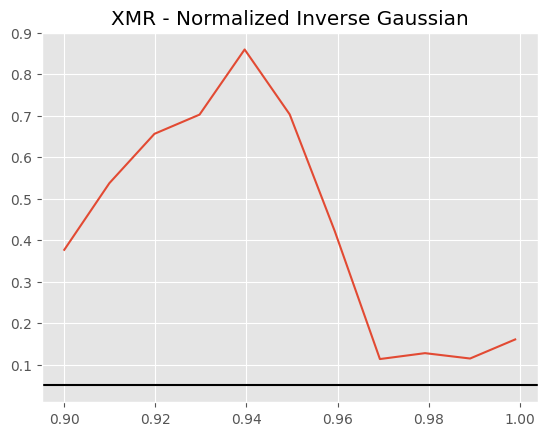

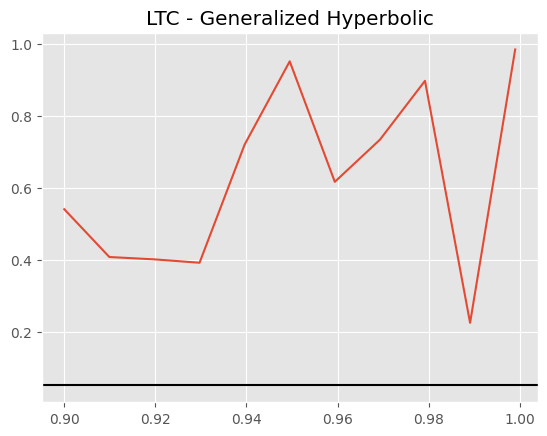

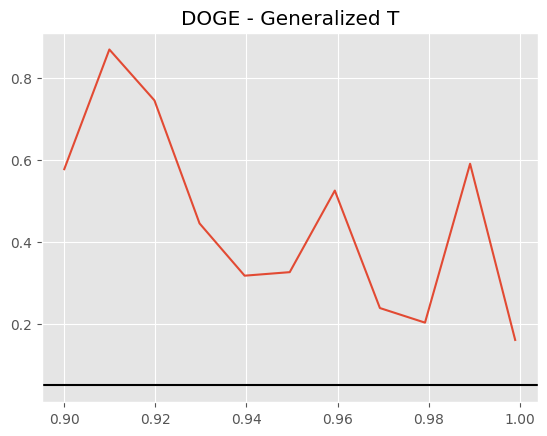

In [9]:

for coin, dist in best_dists.items():
    pydist = info_df[(info_df['coin']==coin)&(info_df['dist']==dist)]['pydist'].iloc[0]
    ax = kupic_plot(pydist)
    ax.set_title(f"{coin} - {dist}"); plt.show()

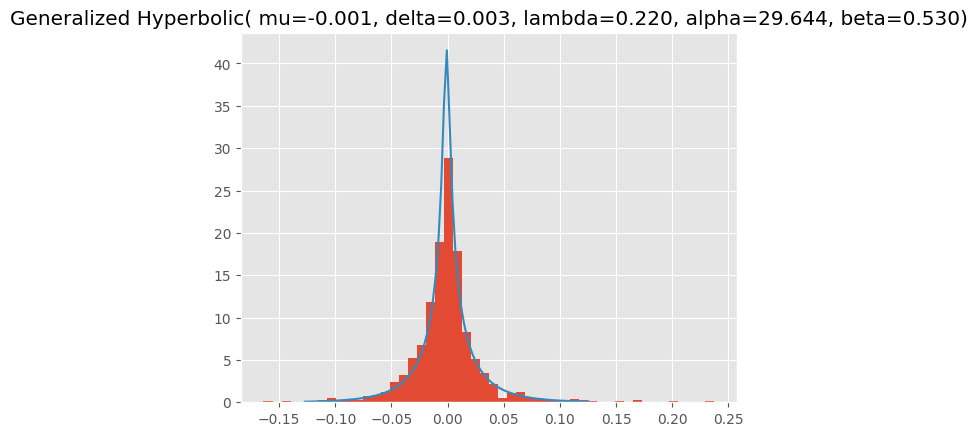

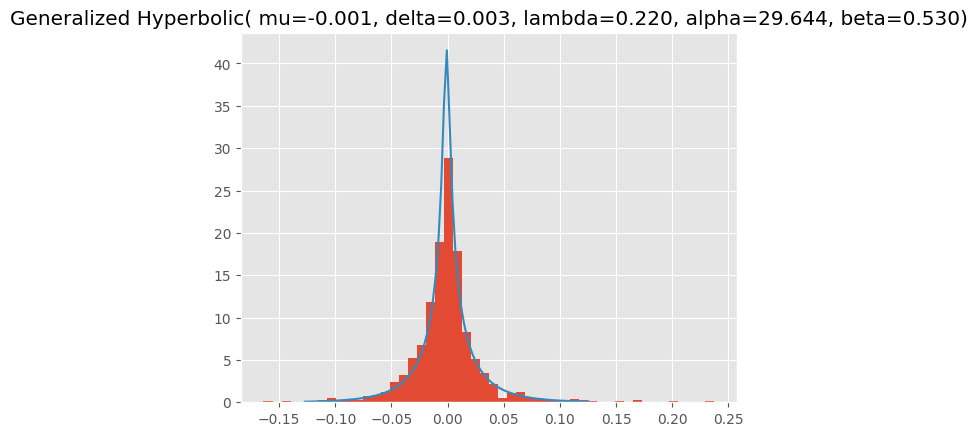

In [23]:
# force dist to be like theirs
test_dist = info_df[(info_df['coin']=='BTC')&(info_df['dist']=='Generalized Hyperbolic')]['pydist'].iloc[0]
test_dist.plot_dist()


from copy import copy 
dist = copy(test_dist)
tmp = -0.001
dist.sol.x = [tmp, 0.003, 0.220, 29.644, 0.530]
dist.plot_dist(); plt.show()